In [3]:
!pip install numpy
!pip install matplotlib
!pip install scipy



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


CHECKING FOR SINGLE .DAT SESSION 1


In [11]:
import numpy as np

# Path to a single trial file
file_path = r"D:\MyoLinkVR\Session1\session1_participant1\session1_participant1_gesture1_trial1.dat"

# Try reading the data (likely float32 and 28 channels)
data = np.fromfile(file_path, dtype=np.float32)


In [12]:
num_channels = 28
print("Total float values:", data.size)

if data.size % num_channels == 0:
    num_samples = data.size // num_channels
    data = data.reshape(num_samples, num_channels)
    print("Data reshaped to:", data.shape)
else:
    print("not 28")

Total float values: 163840
not 28


In [13]:
for ch in range(1, 65):
    if data.size % ch == 0:
        print(f"Possible shape: ({data.size // ch}, {ch})")

Possible shape: (163840, 1)
Possible shape: (81920, 2)
Possible shape: (40960, 4)
Possible shape: (32768, 5)
Possible shape: (20480, 8)
Possible shape: (16384, 10)
Possible shape: (10240, 16)
Possible shape: (8192, 20)
Possible shape: (5120, 32)
Possible shape: (4096, 40)
Possible shape: (2560, 64)


Tring to access single .dat file and preprocess


In [14]:
import numpy as np

file_path = r"D:\MyoLinkVR\Session1\session1_participant1\session1_participant1_gesture1_trial1.dat"
data = np.fromfile(file_path, dtype=np.float32)
data = data.reshape(5120, 32)

In [15]:
# Subtract mean across channels (for each time point)
referenced_data = data - np.mean(data, axis=1, keepdims=True)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13732\484082927.py:2: RuntimeWarning: invalid value encountered in subtract
  referenced_data = data - np.mean(data, axis=1, keepdims=True)


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1355: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


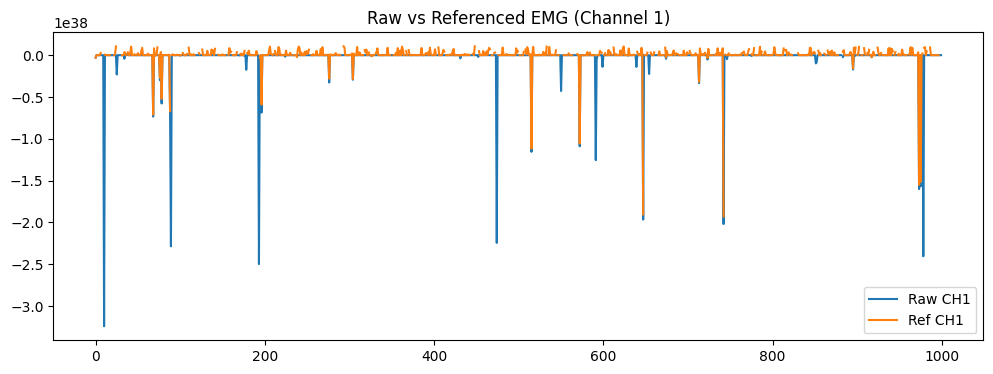

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(data[:1000, 0], label='Raw CH1')
plt.plot(referenced_data[:1000, 0], label='Ref CH1')
plt.legend()
plt.title('Raw vs Referenced EMG (Channel 1)')
plt.show()

In [18]:
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_emg_analysis(data, fs=2048, title_prefix="Raw", channels=[0,1,2,3]):
    """
    Plots time-domain and frequency-domain (PSD) of selected EMG channels.
    """
    plt.figure(figsize=(14, 5))

    # Time domain
    plt.subplot(1, 2, 1)
    for ch in channels:
        plt.plot(data[:1000, ch], label=f'Ch {ch+1}')
    plt.title(f'{title_prefix} EMG - Time Domain')
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()

    # Frequency domain - PSD using Welch method
    plt.subplot(1, 2, 2)
    for ch in channels:
        f, Pxx = welch(data[:, ch], fs=fs, nperseg=1024)
        plt.semilogy(f, Pxx, label=f'Ch {ch+1}')
    plt.title(f'{title_prefix} EMG - Power Spectrum (Welch)')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (V^2/Hz)")
    plt.xlim(0, 1000)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
'''import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import welch

# ==========================
# Configurable Parameters
# ==========================
BASE_PATH = "/content/drive/MyDrive/MyoLINKVR/GrabMyo"
RAW_FOLDER = os.path.join(BASE_PATH, "Session1")  # Change to Session2 or Session3
PROCESSED_FOLDER = os.path.join(BASE_PATH, "ProcessedHOHC", "Session1")
PLOT_FOLDER = os.path.join(BASE_PATH, "PlotsHOHC", "Session1")

NUM_CHANNELS = 32
FS = 2048  # Sampling frequency (Hz)
GESTURE_WHITELIST = ["gesture1", "gesture2"]  # Only HO and HC

os.makedirs(PROCESSED_FOLDER, exist_ok=True)
os.makedirs(PLOT_FOLDER, exist_ok=True)

# ==========================
# Helper Function
# ==========================
def plot_emg_analysis(data, fs, out_path, title_prefix="EMG", channels=[0, 1, 2, 3]):
    plt.figure(figsize=(14, 5))

    # Time Domain
    plt.subplot(1, 2, 1)
    for ch in channels:
        plt.plot(data[:1000, ch], label=f'Ch {ch+1}')
    plt.title(f'{title_prefix} - Time Domain')
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()

    # Frequency Domain (PSD)
    plt.subplot(1, 2, 2)
    for ch in channels:
        f, Pxx = welch(data[:, ch], fs=fs, nperseg=1024)
        plt.semilogy(f, Pxx, label=f'Ch {ch+1}')
    plt.title(f'{title_prefix} - PSD (Welch)')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (V^2/Hz)")
    plt.xlim(0, 1000)
    plt.legend()

    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

# ==========================
# Batch Processing Loop
# ==========================
for participant in tqdm(sorted(os.listdir(RAW_FOLDER))):
    part_path = os.path.join(RAW_FOLDER, participant)
    if not os.path.isdir(part_path):
        continue

    out_part_path = os.path.join(PROCESSED_FOLDER, participant)
    plot_part_path = os.path.join(PLOT_FOLDER, participant)
    os.makedirs(out_part_path, exist_ok=True)
    os.makedirs(plot_part_path, exist_ok=True)

    for file in sorted(os.listdir(part_path)):
        if not file.endswith(".dat") or not any(g in file for g in GESTURE_WHITELIST):
            continue

        file_path = os.path.join(part_path, file)
        out_path = os.path.join(out_part_path, file.replace(".dat", ".npy"))
        plot_path = os.path.join(plot_part_path, file.replace(".dat", ".png"))

        try:
            # Load and reshape
            data = np.fromfile(file_path, dtype=np.float32)
            data = data.reshape(-1, NUM_CHANNELS)

            # Apply average referencing
            referenced = data - np.mean(data, axis=1, keepdims=True)

            # Save as .npy
            np.save(out_path, referenced)

            # Save plot for visualization
            plot_emg_analysis(referenced, fs=FS, out_path=plot_path, title_prefix=file.replace(".dat", "Average Referencing"))

        except Exception as e:
            print(f"Error in {file_path}: {e}")
'''

'import os\nimport numpy as np\nfrom tqdm import tqdm\nimport matplotlib.pyplot as plt\nfrom scipy.signal import welch\n\n# ==========================\n# Configurable Parameters\n# ==========================\nBASE_PATH = "/content/drive/MyDrive/MyoLINKVR/GrabMyo"\nRAW_FOLDER = os.path.join(BASE_PATH, "Session1")  # Change to Session2 or Session3\nPROCESSED_FOLDER = os.path.join(BASE_PATH, "ProcessedHOHC", "Session1")\nPLOT_FOLDER = os.path.join(BASE_PATH, "PlotsHOHC", "Session1")\n\nNUM_CHANNELS = 32\nFS = 2048  # Sampling frequency (Hz)\nGESTURE_WHITELIST = ["gesture1", "gesture2"]  # Only HO and HC\n\nos.makedirs(PROCESSED_FOLDER, exist_ok=True)\nos.makedirs(PLOT_FOLDER, exist_ok=True)\n\n# ==========================\n# Helper Function\n# ==========================\ndef plot_emg_analysis(data, fs, out_path, title_prefix="EMG", channels=[0, 1, 2, 3]):\n    plt.figure(figsize=(14, 5))\n\n    # Time Domain\n    plt.subplot(1, 2, 1)\n    for ch in channels:\n        plt.plot(data[:1000, 

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========== CONFIGURATION ==========
BASE_PATH = "/content/drive/MyDrive/MyoLINKVR/GrabMyo"
RAW_FOLDER = os.path.join(BASE_PATH, "Session1")  # Change to Session2 or Session3
EXPECTED_CHANNELS = 32
MAX_FILES_TO_TEST = 10  # Avoid scanning all 3k files for debugging

# Try different data types commonly used in EMG
DATA_TYPES = [np.float32, np.float64, np.int16]

# ========== FIND ALL .dat FILES ==========
all_dat_files = []
for root, _, files in os.walk(RAW_FOLDER):
    for file in files:
        if file.endswith(".dat"):
            all_dat_files.append(os.path.join(root, file))

# Limit files for quick testing
sample_files = all_dat_files[:MAX_FILES_TO_TEST]

# ========== TEST EACH FILE WITH MULTIPLE DTYPES ==========
for file_path in tqdm(sample_files, desc="🧪 Testing Formats"):
    print(f"\n📂 File: {file_path}")
    file_size = os.path.getsize(file_path)
    print(f"📏 Size: {file_size} bytes")

    for dtype in DATA_TYPES:
        print(f"\n🔍 Trying dtype: {dtype}")
        try:
            raw = np.fromfile(file_path, dtype=dtype)

            # Validate reshape
            if raw.size % EXPECTED_CHANNELS != 0:
                print(f"⚠️ Cannot reshape to ({EXPECTED_CHANNELS} channels) — data size mismatch: {raw.size}")
                continue

            data = raw.reshape(-1, EXPECTED_CHANNELS)
            print(f"✅ Reshaped data: {data.shape}")
            print(f"🔢 Min: {np.nanmin(data)}, Max: {np.nanmax(data)}")
            print(f"📈 Finite check: {np.isfinite(data).all()}")

            # Plot only if finite
            if np.isfinite(data).all():
                plt.figure(figsize=(10, 3))
                plt.plot(data[:1000, 0], label="Channel 1")
                plt.title(f"{os.path.basename(file_path)} - dtype={dtype}")
                plt.legend()
                plt.show()
                break  # ✅ Found correct dtype, no need to test more

        except Exception as e:
            print(f"❌ Error with dtype {dtype}: {e}")

🧪 Testing Formats: 0it [00:00, ?it/s]


In [21]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import welch
# # Removed: from concurrent.futures import ProcessPoolExecutor
# from tqdm import tqdm

# # ==========================
# # Configurable Parameters
# # ==========================
# BASE_PATH = "/content/drive/MyDrive/MyoLINKVR/GrabMyo"
# RAW_FOLDER = os.path.join(BASE_PATH, "Session2")  # Change to Session2 or Session3
# PROCESSED_FOLDER = os.path.join(BASE_PATH, "ProcessedHOHC", "Session2")
# PLOT_FOLDER = os.path.join(BASE_PATH, "PlotsHOHC", "Session2")

# NUM_CHANNELS = 32
# FS = 2048  # Sampling frequency (Hz)
# GESTURE_WHITELIST = ["gesture1", "gesture2"]  # Only HO and HC. IMPORTANT: Verify these match your filenames!

# # === Voltage Conversion Factor based on DeviceInfo ===
# # Device Input Range: 50 mVpp
# # Device Gain: 500
# # Amplified Signal Range = 50 mVpp * 500 = 25000 mVpp = 25 Vpp
# # Data stored as int16 (2^16 = 65536 counts) - confirmed by your debugging
# VOLTAGE_CONVERSION_FACTOR = 25.0 / 65536.0 # Volts per count

# # Define a reasonable clipping threshold for EMG signals (e.g., 5mV = 0.005V)
# # This is applied AFTER voltage conversion.
# EMG_CLIP_THRESHOLD = 0.005 # Volts (5mV) - adjust as needed based on true signal range

# os.makedirs(PROCESSED_FOLDER, exist_ok=True)
# os.makedirs(PLOT_FOLDER, exist_ok=True)

# # ==========================
# # Helper Function
# # ==========================
# def plot_emg_analysis(data, fs, out_path, title_prefix="EMG", channels=[0, 1, 2, 3]):
#     plt.figure(figsize=(14, 5))

#     # Time Domain
#     plt.subplot(1, 2, 1)
#     for ch in channels:
#         # Plotting only the first 1000 samples for better visualization
#         plt.plot(data[:min(1000, len(data)), ch], label=f'Ch {ch+1}')
#     plt.title(f'{title_prefix} - Time Domain')
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (Volts)")
#     plt.legend()

#     # Frequency Domain (PSD)
#     plt.subplot(1, 2, 2)
#     for ch in channels:
#         # Ensure nperseg is not larger than the number of samples in a channel
#         nperseg_val = min(1024, len(data[:, ch]))
#         # Only compute PSD if there are enough samples for nperseg
#         if nperseg_val > 0:
#             f, Pxx = welch(data[:, ch], fs=fs, nperseg=nperseg_val)
#             plt.semilogy(f, Pxx, label=f'Ch {ch+1}')
#     plt.title(f'{title_prefix} - PSD (Welch)')
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("PSD (V^2/Hz)")
#     plt.xlim(0, 1000)
#     plt.legend()

#     plt.tight_layout()
#     plt.savefig(out_path)
#     plt.close()

# # ==========================
# # File Processor
# # ==========================
# def process_file(file_path):
#     try:
#         rel_path = os.path.relpath(file_path, RAW_FOLDER)
#         if not any(g in file_path for g in GESTURE_WHITELIST):
#             return None # Skip files not in the whitelist

#         out_path = os.path.join(PROCESSED_FOLDER, rel_path).replace(".dat", ".npy")
#         plot_path = os.path.join(PLOT_FOLDER, rel_path).replace(".dat", ".png")
#         os.makedirs(os.path.dirname(out_path), exist_ok=True)
#         os.makedirs(os.path.dirname(plot_path), exist_ok=True)

#         # --- CORRECTED: Load data as int16 ---
#         data_int16 = np.fromfile(file_path, dtype=np.int16)

#         if data_int16.size == 0:
#             return f"⚠️ Skipped (empty file): {file_path}"
#         if data_int16.size % NUM_CHANNELS != 0:
#             return f"⚠️ Skipped (bad shape, data size {data_int16.size} not divisible by {NUM_CHANNELS}): {file_path}"

#         data_int16 = data_int16.reshape(-1, NUM_CHANNELS)

#         # --- Convert int16 to float (Volts) using derived factor ---
#         data_volts = data_int16.astype(np.float32) * VOLTAGE_CONVERSION_FACTOR

#         # --- Robust Handling for NaNs, Infs, and Spikes (applied to voltage data) ---
#         data_volts = np.nan_to_num(data_volts, nan=0.0,
#                                    posinf=np.finfo(np.float32).max,
#                                    neginf=np.finfo(np.float32).min)

#         # Clip values that are still extremely large to a sensible EMG range.
#         if np.abs(data_volts).max() > EMG_CLIP_THRESHOLD:
#             data_volts = np.clip(data_volts, a_min=-EMG_CLIP_THRESHOLD, a_max=EMG_CLIP_THRESHOLD)

#         # Average referencing
#         referenced_emg = data_volts - np.mean(data_volts, axis=1, keepdims=True)

#         # Save and plot
#         np.save(out_path, referenced_emg)
#         plot_emg_analysis(referenced_emg, fs=FS, out_path=plot_path, title_prefix=os.path.basename(file_path).replace(".dat", "AvgRef"))
#         return f"✅ Processed: {file_path}"

#     except Exception as e:
#         return f"❌ Error in {file_path}: {e}"

# # ==========================
# # Gather Files
# # ==========================
# all_files = []
# if not os.path.exists(RAW_FOLDER):
#     print(f"Error: RAW_FOLDER '{RAW_FOLDER}' does not exist. Please check your BASE_PATH and RAW_FOLDER settings.")
# else:
#     for participant in sorted(os.listdir(RAW_FOLDER)):
#         part_path = os.path.join(RAW_FOLDER, participant)
#         if not os.path.isdir(part_path):
#             continue
#         for file in sorted(os.listdir(part_path)):
#             if file.endswith(".dat") and any(g in file for g in GESTURE_WHITELIST):
#                 all_files.append(os.path.join(part_path, file))

# # ==========================
# # Sequential Processing
# # ==========================
# results = []
# if all_files:
#     print(f"Found {len(all_files)} files matching whitelist in {RAW_FOLDER}. Starting sequential processing...")
#     # Loop directly over files, calling process_file for each
#     for file_path in tqdm(all_files):
#         result = process_file(file_path)
#         results.append(result)
# else:
#     print(f"No .dat files found in {RAW_FOLDER} matching the GESTURE_WHITELIST: {GESTURE_WHITELIST}")

# # ==========================
# # Log Summary
# # ==========================
# skipped = [r for r in results if r and ("Skipped" in r or "Error" in r)]
# processed = [r for r in results if r and "✅" in r]

# print(f"\n✅ Successfully processed: {len(processed)} files")
# print(f"⚠️ Skipped or errored: {len(skipped)} files\n")

# log_file_path = os.path.join(BASE_PATH, "processing_log.txt")
# with open(log_file_path, "w") as f:
#     for r in results:
#         if r:
#             f.write(r + "\n")
# print(f"Processing log saved to: {log_file_path}")

# if skipped:
#     print("\n⚠️ Skipped files summary:")
#     for s in skipped:
#         print(s)

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from tqdm import tqdm
# import traceback # Uncomment this if you need a full traceback for deeper debugging

# ==========================
# Configurable Parameters
# ==========================
BASE_PATH = r"D:\MyoLinkVR\grabmyo"
RAW_FOLDER = os.path.join(BASE_PATH, "Session1")  # Change to Session2 or Session3
PROCESSED_FOLDER = os.path.join(BASE_PATH, "ProcessedHOHC", "Session1")
PLOT_FOLDER = os.path.join(BASE_PATH, "PlotsHOHC", "Session1")

NUM_CHANNELS = 32
FS = 2048  # Sampling frequency (Hz)
GESTURE_WHITELIST = ["gesture1", "gesture2"]  # Only HO and HC. IMPORTANT: Verify these match your filenames!

# === Voltage Conversion Factor based on DeviceInfo ===
# Device Input Range: 50 mVpp
# Device Gain: 500
# Amplified Signal Range = 50 mVpp * 500 = 25000 mVpp = 25 Vpp
# Data stored as int16 (2^16 = 65536 counts) - confirmed by your debugging
VOLTAGE_CONVERSION_FACTOR = 25.0 / 65536.0 # Volts per count

# Define a reasonable clipping threshold for EMG signals (e.g., 5mV = 0.005V)
# This is applied AFTER voltage conversion.
EMG_CLIP_THRESHOLD = 0.005 # Volts (5mV) - adjust as needed based on true signal range

os.makedirs(PROCESSED_FOLDER, exist_ok=True)
os.makedirs(PLOT_FOLDER, exist_ok=True)

# ==========================
# Helper Function
# ==========================
def plot_emg_analysis(data, fs, out_path, title_prefix="EMG", channels=[0, 1, 2, 3]):
    plt.figure(figsize=(14, 5))

    # Time Domain
    plt.subplot(1, 2, 1)
    for ch in channels:
        # Plotting only the first 1000 samples for better visualization
        plt.plot(data[:min(1000, len(data)), ch], label=f'Ch {ch+1}')
    plt.title(f'{title_prefix} - Time Domain')
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (Volts)")
    plt.legend()

    # Frequency Domain (PSD)
    plt.subplot(1, 2, 2)
    for ch in channels:
        # Ensure nperseg is not larger than the number of samples in a channel
        nperseg_val = min(1024, len(data[:, ch]))
        # Only compute PSD if there are enough samples for nperseg
        if nperseg_val > 0:
            f, Pxx = welch(data[:, ch], fs=fs, nperseg=nperseg_val)
            plt.semilogy(f, Pxx, label=f'Ch {ch+1}')
    plt.title(f'{title_prefix} - PSD (Welch)')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (V^2/Hz)")
    plt.xlim(0, 1000)
    plt.legend()

    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

# ==========================
# File Processor
# ==========================
def process_file(file_path):
    try:
        rel_path = os.path.relpath(file_path, RAW_FOLDER)
        if not any(g in file_path for g in GESTURE_WHITELIST):
            return None # Skip files not in the whitelist

        out_path = os.path.join(PROCESSED_FOLDER, rel_path).replace(".dat", ".npy")
        plot_path = os.path.join(PLOT_FOLDER, rel_path).replace(".dat", ".png")
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        os.makedirs(os.path.dirname(plot_path), exist_ok=True)

        # --- CORRECTED: Load data as int16 ---
        data_int16 = np.fromfile(file_path, dtype=np.int16)

        if data_int16.size == 0:
            return f"⚠️ Skipped (empty file): {file_path}"
        if data_int16.size % NUM_CHANNELS != 0:
            return f"⚠️ Skipped (bad shape, data size {data_int16.size} not divisible by {NUM_CHANNELS}): {file_path}"

        data_int16 = data_int16.reshape(-1, NUM_CHANNELS)

        # --- Convert int16 to float (Volts) using derived factor ---
        data_volts = data_int16.astype(np.float32) * VOLTAGE_CONVERSION_FACTOR

        # --- Robust Handling for NaNs, Infs, and Spikes (applied to voltage data) ---
        data_volts = np.nan_to_num(data_volts, nan=0.0,
                                   posinf=np.finfo(np.float32).max,
                                   neginf=np.finfo(np.float32).min)

        # Clip values that are still extremely large to a sensible EMG range.
        if np.abs(data_volts).max() > EMG_CLIP_THRESHOLD:
            data_volts = np.clip(data_volts, a_min=-EMG_CLIP_THRESHOLD, a_max=EMG_CLIP_THRESHOLD)

        # Average referencing
        referenced_emg = data_volts - np.mean(data_volts, axis=1, keepdims=True)

        # Save and plot
        np.save(out_path, referenced_emg)
        plot_emg_analysis(referenced_emg, fs=FS, out_path=plot_path, title_prefix=os.path.basename(file_path).replace(".dat", "AvgRef"))
        return f"✅ Processed: {file_path}"

    except Exception as e:
        # This internal try-except is good for logging errors that are Python-level and handled.
        # But if the process crashes, this specific return might not be reached.
        return f"❌ Error in {file_path}: {e}"

# ==========================
# Gather Files
# ==========================
all_files = []
if not os.path.exists(RAW_FOLDER):
    print(f"Error: RAW_FOLDER '{RAW_FOLDER}' does not exist. Please check your BASE_PATH and RAW_FOLDER settings.")
else:
    for participant in sorted(os.listdir(RAW_FOLDER)):
        part_path = os.path.join(RAW_FOLDER, participant)
        if not os.path.isdir(part_path):
            continue
        for file in sorted(os.listdir(part_path)):
            if file.endswith(".dat") and any(g in file for g in GESTURE_WHITELIST):
                all_files.append(os.path.join(part_path, file))

# ==========================
# Sequential Processing
# ==========================
results = []
if all_files:
    print(f"Found {len(all_files)} files matching whitelist in {RAW_FOLDER}. Starting sequential processing...")
    # Loop directly over files, calling process_file for each
    for file_path in tqdm(all_files):
        # *** THIS IS THE CRUCIAL OUTER TRY-EXCEPT BLOCK ***
        try:
            result = process_file(file_path)
            results.append(result)
        except Exception as e:
            # This catches *any* error that causes the process_file call to fail
            # and prevents the entire script from stopping.
            error_message = f"❌ CRITICAL CRASH ERROR for {file_path}: {e}"
            results.append(error_message)
            print(error_message) # Print immediately so you see it
            # if 'traceback' in globals(): # Uncommented if you uncommented import traceback
            #     traceback.print_exc() # Print full traceback for deeper insights
else:
    print(f"No .dat files found in {RAW_FOLDER} matching the GESTURE_WHITELIST: {GESTURE_WHITELIST}")

# ==========================
# Log Summary
# ==========================
# Updated 'skipped' condition to include the new CRITICAL CRASH ERROR messages
skipped = [r for r in results if r and ("Skipped" in r or "Error" in r or "CRITICAL CRASH ERROR" in r)]
processed = [r for r in results if r and "✅" in r]

print(f"\n✅ Successfully processed: {len(processed)} files")
print(f"⚠️ Skipped or errored: {len(skipped)} files\n")

log_file_path = os.path.join(BASE_PATH, "processing_log.txt")
with open(log_file_path, "w") as f:
    for r in results:
        if r:
            f.write(r + "\n")
print(f"Processing log saved to: {log_file_path}")

if skipped:
    print("\n⚠️ Skipped files summary:")
    for s in skipped:
        print(s)

Found 3010 files matching whitelist in D:\MyoLinkVR\grabmyo\Session1. Starting sequential processing...


100%|██████████████████████████████████████████████████████████████████████████████| 3010/3010 [22:29<00:00,  2.23it/s]


✅ Successfully processed: 3010 files
⚠️ Skipped or errored: 0 files



UnicodeEncodeError: 'charmap' codec can't encode character '\u2705' in position 0: character maps to <undefined>

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from tqdm.notebook import tqdm  # 🟢 Jupyter-friendly progress bar!

# ==========================
# 💡 Configurable Parameters
# ==========================
BASE_PATH = r"D:\MyoLinkVR\grabmyo"

RAW_FOLDER = os.path.join(BASE_PATH, "Session1")
PROCESSED_FOLDER = os.path.join(BASE_PATH, "ProcessedHOHC", "Session1")
BANDPASS_FOLDER = os.path.join(BASE_PATH, "BandpassedHOHC", "Session1")
PSD_PLOT_FOLDER = os.path.join(BASE_PATH, "BandpassedHOHC_Plots", "Session1")

NUM_CHANNELS = 32
FS = 2048
LOWCUT = 20
HIGHCUT = 450
FILTER_ORDER = 4
CHANNEL_TO_PLOT = 0

os.makedirs(BANDPASS_FOLDER, exist_ok=True)
os.makedirs(PSD_PLOT_FOLDER, exist_ok=True)

# ==========================
# 🎚️ Band-pass Filter Function
# ==========================
def butter_bandpass_filter(data, lowcut=20, highcut=450, fs=2048, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# ==========================
# 📊 PSD Plotting Function
# ==========================
def plot_psd_comparison(before, after, fs, out_path, channel=0):
    plt.figure(figsize=(10, 5))
    f1, pxx1 = welch(before[:, channel], fs=fs, nperseg=1024)
    f2, pxx2 = welch(after[:, channel], fs=fs, nperseg=1024)
    plt.semilogy(f1, pxx1, label="Before Filtering")
    plt.semilogy(f2, pxx2, label="After Filtering")
    plt.title(f"Channel {channel + 1} - PSD Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (V²/Hz)")
    plt.legend()
    plt.xlim(0, 1000)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

# ==========================
# 🔁 Process & Show Progress
# ==========================
bandpassed_results = []

# Gather all files first
all_files = []
for root, _, files in os.walk(PROCESSED_FOLDER):
    for file in files:
        if file.endswith(".npy"):
            in_path = os.path.join(root, file)
            rel_path = os.path.relpath(in_path, PROCESSED_FOLDER)
            out_path = os.path.join(BANDPASS_FOLDER, rel_path)
            plot_path = os.path.join(PSD_PLOT_FOLDER, rel_path.replace(".npy", "_psd.png"))
            all_files.append((in_path, out_path, plot_path))

# 🟡 Show tqdm progress bar
for in_path, out_path, plot_path in tqdm(all_files, desc="Applying Band-Pass Filter"):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)

    try:
        data = np.load(in_path)
        filtered = butter_bandpass_filter(data, lowcut=LOWCUT, highcut=HIGHCUT, fs=FS, order=FILTER_ORDER)
        np.save(out_path, filtered)
        plot_psd_comparison(before=data, after=filtered, fs=FS, out_path=plot_path, channel=CHANNEL_TO_PLOT)
        bandpassed_results.append(f"✅ Filtered & plotted: {in_path}")
    except Exception as e:
        bandpassed_results.append(f"❌ Error: {in_path} → {e}")

# ==========================
# 📋 Summary
# ==========================
success_count = sum("✅" in r for r in bandpassed_results)
fail_count = sum("❌" in r for r in bandpassed_results)

print(f"\n✅ Successfully filtered and plotted PSD: {success_count} files")
print(f"❌ Failed to process: {fail_count} files\n")

for line in bandpassed_results:
    print(line)


Applying Band-Pass Filter:   0%|          | 0/3010 [00:00<?, ?it/s]


✅ Successfully filtered and plotted PSD: 3010 files
❌ Failed to process: 0 files

✅ Filtered & plotted: D:\MyoLinkVR\grabmyo\ProcessedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial1.npy
✅ Filtered & plotted: D:\MyoLinkVR\grabmyo\ProcessedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial2.npy
✅ Filtered & plotted: D:\MyoLinkVR\grabmyo\ProcessedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial3.npy
✅ Filtered & plotted: D:\MyoLinkVR\grabmyo\ProcessedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial4.npy
✅ Filtered & plotted: D:\MyoLinkVR\grabmyo\ProcessedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial5.npy
✅ Filtered & plotted: D:\MyoLinkVR\grabmyo\ProcessedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial6.npy
✅ Filtered & plotted: D:\MyoLinkVR\grabmyo\ProcessedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial7.npy


In [17]:

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
from tqdm.notebook import tqdm

# ==========================
# 💡 Configurable Parameters
# ==========================
BASE_PATH = r"D:\MyoLinkVR\grabmyo"

BANDPASS_FOLDER = os.path.join(BASE_PATH, "BandpassedHOHC", "Session1")
NOTCHED_FOLDER = os.path.join(BASE_PATH, "NotchedHOHC", "Session1")
PSD_PLOT_FOLDER = os.path.join(BASE_PATH, "NotchedHOHC_Plots", "Session1")

NUM_CHANNELS = 32
FS = 2048
NOTCH_FREQ = 50          # Target frequency to remove (e.g., 50Hz mains noise)
QUALITY_FACTOR = 30      # Notch sharpness
CHANNEL_TO_PLOT = 0

os.makedirs(NOTCHED_FOLDER, exist_ok=True)
os.makedirs(PSD_PLOT_FOLDER, exist_ok=True)

# ==========================
# ❌ Notch Filter Function
# ==========================
def apply_notch_filter(data, fs=2048, freq=50, q=30):
    b, a = iirnotch(w0=freq / (0.5 * fs), Q=q)
    return filtfilt(b, a, data, axis=0)

# ==========================
# 📊 PSD Plotting Function
# ==========================
def plot_psd_comparison(before, after, fs, out_path, channel=0):
    plt.figure(figsize=(10, 5))
    f1, pxx1 = welch(before[:, channel], fs=fs, nperseg=1024)
    f2, pxx2 = welch(after[:, channel], fs=fs, nperseg=1024)

    plt.semilogy(f1, pxx1, label="Before Notch")
    plt.semilogy(f2, pxx2, label="After Notch")

    plt.title(f"Channel {channel + 1} - Notch Filter PSD Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (V²/Hz)")
    plt.xlim(0, 1000)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

# ==========================
# 🔁 Apply Notch to All Files
# ==========================
notch_results = []

all_files = []
for root, _, files in os.walk(BANDPASS_FOLDER):
    for file in files:
        if file.endswith(".npy"):
            in_path = os.path.join(root, file)
            rel_path = os.path.relpath(in_path, BANDPASS_FOLDER)
            out_path = os.path.join(NOTCHED_FOLDER, rel_path)
            plot_path = os.path.join(PSD_PLOT_FOLDER, rel_path.replace(".npy", "_notch_psd.png"))
            all_files.append((in_path, out_path, plot_path))

for in_path, out_path, plot_path in tqdm(all_files, desc="Applying Notch Filter", position=0, leave=True, dynamic_ncols=True):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)

    try:
        data = np.load(in_path)

        # Apply notch filter
        notched = apply_notch_filter(data, fs=FS, freq=NOTCH_FREQ, q=QUALITY_FACTOR)

        # Save filtered output
        np.save(out_path, notched)

        # Plot PSD comparison
        plot_psd_comparison(before=data, after=notched, fs=FS, out_path=plot_path, channel=CHANNEL_TO_PLOT)

        notch_results.append(f"✅ Notched & plotted: {in_path}")

    except Exception as e:
        notch_results.append(f"❌ Error: {in_path} → {e}")

# ==========================
# 📋 Summary
# ==========================
success = [r for r in notch_results if "✅" in r]
fail = [r for r in notch_results if "❌" in r]

print(f"\n✅ Successfully notch filtered & plotted: {len(success)} files")
print(f"❌ Failed: {len(fail)} files\n")
for line in notch_results:
    print(line)


Applying Notch Filter:   0%|                                                                  | 0/3010 [00:00<…


✅ Successfully notch filtered & plotted: 3010 files
❌ Failed: 0 files

✅ Notched & plotted: D:\MyoLinkVR\grabmyo\BandpassedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial1.npy
✅ Notched & plotted: D:\MyoLinkVR\grabmyo\BandpassedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial2.npy
✅ Notched & plotted: D:\MyoLinkVR\grabmyo\BandpassedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial3.npy
✅ Notched & plotted: D:\MyoLinkVR\grabmyo\BandpassedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial4.npy
✅ Notched & plotted: D:\MyoLinkVR\grabmyo\BandpassedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial5.npy
✅ Notched & plotted: D:\MyoLinkVR\grabmyo\BandpassedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial6.npy
✅ Notched & plotted: D:\MyoLinkVR\grabmyo\BandpassedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial7.npy
✅ Notched &

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from tqdm.notebook import tqdm

# ==========================
# 💡 Configurable Parameters
# ==========================
BASE_PATH = r"D:\MyoLinkVR\grabmyo"

RAW_FOLDER = os.path.join(BASE_PATH, "Session1")
INPUT_FOLDER = os.path.join(BASE_PATH, "NotchedHOHC", "Session1")  # <-- INPUT = after notch
HPF_FOLDER = os.path.join(BASE_PATH, "HighpassHOHC", "Session1")   # <-- OUTPUT = after high-pass
PSD_PLOT_FOLDER = os.path.join(BASE_PATH, "HighpassHOHC_Plots", "Session1")  # PSD plots

NUM_CHANNELS = 32
FS = 2048
HPF_CUTOFF = 0.1          # Hz (to remove DC offset)
HPF_ORDER = 4
CHANNEL_TO_PLOT = 0       # Index 0 = Channel 1

os.makedirs(HPF_FOLDER, exist_ok=True)
os.makedirs(PSD_PLOT_FOLDER, exist_ok=True)

# ==========================
# 🔼 High-Pass Filter Function
# ==========================
def butter_highpass_filter(data, cutoff=0.1, fs=2048, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high')
    return filtfilt(b, a, data, axis=0)

# ==========================
# 📊 PSD Plotting Function
# ==========================
def plot_psd_comparison(before, after, fs, out_path, channel=0):
    plt.figure(figsize=(10, 5))
    f1, pxx1 = welch(before[:, channel], fs=fs, nperseg=1024)
    f2, pxx2 = welch(after[:, channel], fs=fs, nperseg=1024)

    plt.semilogy(f1, pxx1, label="Before High-Pass")
    plt.semilogy(f2, pxx2, label="After High-Pass")

    plt.title(f"Channel {channel + 1} - High-Pass Filter PSD Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (V²/Hz)")
    plt.xlim(0, 1000)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

# ==========================
# 🔁 Apply High-Pass Filter to All Files
# ==========================
hpf_results = []

all_files = []
for root, _, files in os.walk(INPUT_FOLDER):
    for file in files:
        if file.endswith(".npy"):
            in_path = os.path.join(root, file)
            rel_path = os.path.relpath(in_path, INPUT_FOLDER)
            out_path = os.path.join(HPF_FOLDER, rel_path)
            plot_path = os.path.join(PSD_PLOT_FOLDER, rel_path.replace(".npy", "_hpf_psd.png"))
            all_files.append((in_path, out_path, plot_path))

for in_path, out_path, plot_path in tqdm(all_files, desc="Applying High-Pass Filter (0.1 Hz)", position=0, leave=True, dynamic_ncols=True):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)

    try:
        data = np.load(in_path)

        # Apply high-pass filter
        filtered = butter_highpass_filter(data, cutoff=HPF_CUTOFF, fs=FS, order=HPF_ORDER)

        # Save output
        np.save(out_path, filtered)

        # PSD Comparison
        plot_psd_comparison(before=data, after=filtered, fs=FS, out_path=plot_path, channel=CHANNEL_TO_PLOT)

        hpf_results.append(f"✅ High-pass filtered & plotted: {in_path}")

    except Exception as e:
        hpf_results.append(f"❌ Error: {in_path} → {e}")

# ==========================
# 📋 Summary
# ==========================
success = [r for r in hpf_results if "✅" in r]
fail = [r for r in hpf_results if "❌" in r]

print(f"\n✅ Successfully high-pass filtered & plotted: {len(success)} files")
print(f"❌ Failed: {len(fail)} files\n")
for line in hpf_results:
    print(line)


Applying High-Pass Filter (0.1 Hz):   0%|                                                     | 0/3010 [00:00<…


✅ Successfully high-pass filtered & plotted: 3010 files
❌ Failed: 0 files

✅ High-pass filtered & plotted: D:\MyoLinkVR\grabmyo\NotchedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial1.npy
✅ High-pass filtered & plotted: D:\MyoLinkVR\grabmyo\NotchedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial2.npy
✅ High-pass filtered & plotted: D:\MyoLinkVR\grabmyo\NotchedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial3.npy
✅ High-pass filtered & plotted: D:\MyoLinkVR\grabmyo\NotchedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial4.npy
✅ High-pass filtered & plotted: D:\MyoLinkVR\grabmyo\NotchedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial5.npy
✅ High-pass filtered & plotted: D:\MyoLinkVR\grabmyo\NotchedHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial6.npy
✅ High-pass filtered & plotted: D:\MyoLinkVR\grabmyo\NotchedHOHC\Session1\session1_partici

In [ ]:
pip install PyWavelets

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pywt
from tqdm.notebook import tqdm

# ==========================
# 💡 Configurable Parameters
# ==========================
BASE_PATH = r"D:\MyoLinkVR\grabmyo"

INPUT_FOLDER = os.path.join(BASE_PATH, "HighpassHOHC", "Session1")  # Input from previous filtering
DWT_OUTPUT_FOLDER = os.path.join(BASE_PATH, "DWT_Coefficients", "Session1")  # Save coeffs here
DWT_PLOT_FOLDER = os.path.join(BASE_PATH, "DWT_Plots", "Session1")  # Save PSD plot here

NUM_CHANNELS = 32
WAVELET = 'bior3.3'
LEVELS = 4
CHANNEL_TO_PLOT = 0

os.makedirs(DWT_OUTPUT_FOLDER, exist_ok=True)
os.makedirs(DWT_PLOT_FOLDER, exist_ok=True)

# ==========================
# 📊 DWT Coefficient Plotting
# ==========================
def plot_dwt_coeffs(coeffs, out_path, title="DWT Coefficients", channel=0):
    plt.figure(figsize=(12, 6))
    for i, c in enumerate(coeffs[1:], 1):
        plt.plot(c[channel], label=f"Detail L{i}")
    plt.plot(coeffs[0][channel], label="Approx Level 4", linestyle='--')
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()  # 🧠 avoid memory leak!

# ==========================
# 🔁 Process All Files
# ==========================
dwt_results = []

# Gather files first
all_files = []
for root, _, files in os.walk(INPUT_FOLDER):
    for file in files:
        if file.endswith(".npy"):
            in_path = os.path.join(root, file)
            rel_path = os.path.relpath(in_path, INPUT_FOLDER)
            base_name = rel_path.replace(".npy", "")
            out_dir = os.path.join(DWT_OUTPUT_FOLDER, base_name)
            plot_path = os.path.join(DWT_PLOT_FOLDER, base_name + "_dwt.png")
            all_files.append((in_path, out_dir, plot_path))

# Apply DWT
for in_path, out_dir, plot_path in tqdm(all_files, desc="Applying DWT (4 Levels, bior3.3)", dynamic_ncols=True):
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)  # ✅ FIXED

    try:
        data = np.load(in_path)

        # DWT channel-wise
        approx_coeffs = []
        detail_coeffs = [[] for _ in range(LEVELS)]

        for ch in range(NUM_CHANNELS):
            coeffs = pywt.wavedec(data[:, ch], wavelet=WAVELET, level=LEVELS)
            approx_coeffs.append(coeffs[0])
            for lvl in range(LEVELS):
                detail_coeffs[lvl].append(coeffs[lvl + 1])

        # Save arrays
        approx_array = np.array(approx_coeffs)
        np.save(os.path.join(out_dir, "approximation_level4.npy"), approx_array)

        for lvl, detail in enumerate(detail_coeffs, 1):
            detail_array = np.array(detail)
            np.save(os.path.join(out_dir, f"detail_level{lvl}.npy"), detail_array)

        # Plot
        plot_dwt_coeffs([approx_array] + detail_coeffs, out_path=plot_path, title=base_name, channel=CHANNEL_TO_PLOT)

        dwt_results.append(f"✅ DWT completed: {in_path}")

    except Exception as e:
        dwt_results.append(f"❌ Error: {in_path} → {e}")

# ==========================
# 📋 Summary
# ==========================
success = [r for r in dwt_results if "✅" in r]
fail = [r for r in dwt_results if "❌" in r]

print(f"\n✅ Successfully DWT decomposed: {len(success)} files")
print(f"❌ Failed: {len(fail)} files\n")

for line in dwt_results:
    print(line)


Applying DWT (4 Levels, bior3.3):   0%|                                                       | 0/3010 [00:00<…


✅ Successfully DWT decomposed: 3010 files
❌ Failed: 0 files

✅ DWT completed: D:\MyoLinkVR\grabmyo\HighpassHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial1.npy
✅ DWT completed: D:\MyoLinkVR\grabmyo\HighpassHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial2.npy
✅ DWT completed: D:\MyoLinkVR\grabmyo\HighpassHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial3.npy
✅ DWT completed: D:\MyoLinkVR\grabmyo\HighpassHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial4.npy
✅ DWT completed: D:\MyoLinkVR\grabmyo\HighpassHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial5.npy
✅ DWT completed: D:\MyoLinkVR\grabmyo\HighpassHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial6.npy
✅ DWT completed: D:\MyoLinkVR\grabmyo\HighpassHOHC\Session1\session1_participant1\session1_participant1_gesture10_trial7.npy
✅ DWT completed: D:\MyoLinkVR\grabmyo\HighpassHOHC\Session1\ses

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# ==========================
# 💡 Configurable Parameters
# ==========================
BASE_PATH = r"D:\MyoLinkVR\grabmyo"
DWT_FOLDER = os.path.join(BASE_PATH, "DWT_Coefficients", "Session1")
FEATURES_CSV = os.path.join(BASE_PATH, "features_DWT.csv")

NUM_CHANNELS = 32
DWT_LEVELS = 4
ZC_THRESHOLD = 1e-6  # Threshold for ZC and SSC
EWL_P = 0.75

# ==========================
# 🔍 Feature Functions
# ==========================
def MAV(x): return np.mean(np.abs(x))
def WL(x): return np.sum(np.abs(np.diff(x)))
def RMS(x): return np.sqrt(np.mean(x**2))

def ZC(x, threshold=ZC_THRESHOLD):
    return np.sum(((x[:-1] * x[1:]) < 0) & (np.abs(x[:-1] - x[1:]) >= threshold))

def SSC(x, threshold=ZC_THRESHOLD):
    return np.sum(
        ((x[1:-1] - x[:-2]) * (x[2:] - x[1:-1]) < 0) &
        (np.abs(x[2:] - x[:-2]) >= threshold)
    )

def EWL(x, p=EWL_P):
    return np.sum(np.abs(x)**p)

def EMAV(x, p=EWL_P):
    weights = np.where((np.abs(x) > 0.2) & (np.abs(x) < 0.8), p, 0.5)
    return np.mean(np.abs(x) * weights)

# ==========================
# 🧠 Process All DWT Files
# ==========================
rows = []

for root, _, files in tqdm(os.walk(DWT_FOLDER), desc="Extracting Features from DWT"):
    if "approximation_level4.npy" not in files:
        continue

    rel_path = os.path.relpath(root, DWT_FOLDER)
    base_name = rel_path.replace(os.sep, "_")

    # Process approximation
    approx = np.load(os.path.join(root, "approximation_level4.npy"))  # shape: (channels, ?)
    for ch in range(NUM_CHANNELS):
        x = approx[ch]
        rows.append({
            "file": base_name,
            "channel": ch,
            "level": "A4",
            "MAV": MAV(x),
            "WL": WL(x),
            "ZC": ZC(x),
            "SSC": SSC(x),
            "RMS": RMS(x),
            "EWL": EWL(x),
            "EMAV": EMAV(x),
        })

    # Process details (1 to 4)
    for level in range(1, DWT_LEVELS + 1):
        file_name = f"detail_level{level}.npy"
        detail_path = os.path.join(root, file_name)
        if not os.path.exists(detail_path):
            continue

        detail = np.load(detail_path)
        for ch in range(NUM_CHANNELS):
            x = detail[ch]
            rows.append({
                "file": base_name,
                "channel": ch,
                "level": f"D{level}",
                "MAV": MAV(x),
                "WL": WL(x),
                "ZC": ZC(x),
                "SSC": SSC(x),
                "RMS": RMS(x),
                "EWL": EWL(x),
                "EMAV": EMAV(x),
            })

# ==========================
# 📁 Save to CSV
# ==========================
df = pd.DataFrame(rows)
df.to_csv(FEATURES_CSV, index=False)
print(f"\n✅ Feature extraction complete. Saved to:\n{FEATURES_CSV}")


Extracting Features from DWT: 0it [00:00, ?it/s]


✅ Feature extraction complete. Saved to:
D:\MyoLinkVR\grabmyo\features_DWT.csv


In [6]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# from tqdm.notebook import tqdm

# # ================================
# # 🔧 CONFIG
# # ================================
# FEATURES_CSV = r"D:\MyoLinkVR\grabmyo\copyfeatures2_DWT.csv"

# # ================================
# # 📥 LOAD & FLATTEN FEATURES
# # ================================
# print("📥 Loading feature data...")
# df = pd.read_csv(FEATURES_CSV)

# # Create full feature label: MAV_D1_C0 etc.
# df["feature_group"] = df["level"] + "_C" + df["channel"].astype(str)
# flat_df = df.melt(id_vars=["file", "feature_group"],
#                   value_vars=["MAV", "WL", "ZC", "SSC", "RMS", "EWL", "EMAV"],
#                   var_name="feature", value_name="value")
# flat_df["full_feature"] = flat_df["feature"] + "_" + flat_df["feature_group"]

# # Pivot to wide format
# X_df = flat_df.pivot(index="file", columns="full_feature", values="value").reset_index()

# # ================================
# # 🏷️ EXTRACT LABEL (gestureX)
# # ================================
# print("🏷️ Extracting gesture labels...")
# X_df["label"] = X_df["file"].apply(lambda f: [part for part in f.split("_") if "gesture" in part][0])

# # ================================
# # 🧪 TRAIN-TEST SPLIT
# # ================================
# X = X_df.drop(columns=["file", "label"])
# y = X_df["label"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # ================================
# # 🧠 TRAIN LDA
# # ================================
# lda = LinearDiscriminantAnalysis(n_components=None)
# X_train_lda = lda.fit_transform(X_train, y_train)
# X_test_lda = lda.transform(X_test)
# y_pred = lda.predict(X_test)

# # ================================
# # 📊 EVALUATION
# # ================================
# print("\n📊 Classification Report:")
# print(classification_report(y_test, y_pred))
# print("✅ Accuracy:", accuracy_score(y_test, y_pred))
# print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# # ================================
# # 📈 LDA VISUALIZATION (1D Projection)
# # ================================
# X_all_lda = lda.transform(X)
# plt.figure(figsize=(10, 4))

# for label in np.unique(y):
#     idx = (y == label)
#     plt.scatter(X_all_lda[idx, 0], [0]*np.sum(idx), label=label, alpha=0.7)

# plt.title("LDA Projection (1D) — Gesture Separation")
# plt.xlabel("Linear Discriminant 1")
# plt.yticks([])
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


📥 Loading feature data...
🏷️ Extracting gesture labels...

📊 Classification Report:
              precision    recall  f1-score   support

   gesture11       0.81      0.93      0.87        60
   gesture12       0.78      0.75      0.76        60
   gesture13       0.76      0.73      0.75        60
   gesture14       0.73      0.62      0.67        61
   gesture15       0.55      0.58      0.56        60
   gesture16       0.78      0.87      0.82        60
   gesture17       0.80      0.70      0.75        61

    accuracy                           0.74       422
   macro avg       0.74      0.74      0.74       422
weighted avg       0.74      0.74      0.74       422

✅ Accuracy: 0.7417061611374408
🧩 Confusion Matrix:
 [[56  0  1  0  3  0  0]
 [ 1 45  3  1  4  3  3]
 [ 2  2 44  3  1  4  4]
 [ 2  6  3 38  9  2  1]
 [ 7  1  7  7 35  2  1]
 [ 0  1  0  0  5 52  2]
 [ 1  3  0  3  7  4 43]]


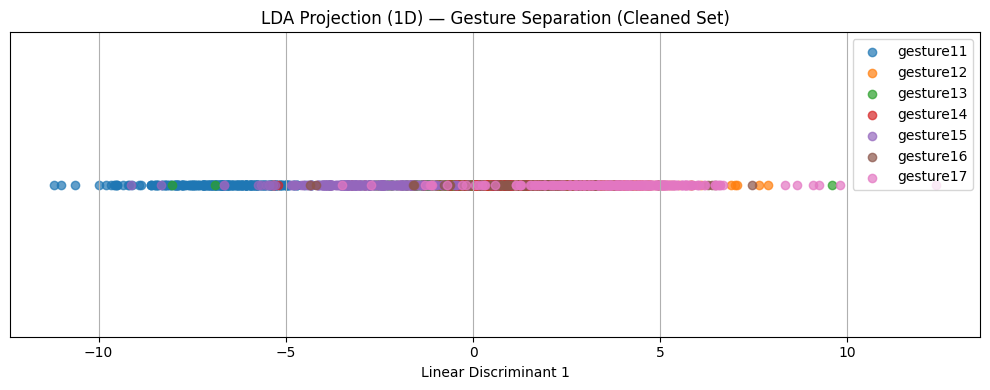

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm.notebook import tqdm

# ================================
# 🔧 CONFIG
# ================================
FEATURES_CSV = r"D:\MyoLinkVR\grabmyo\copyfeatures2_DWT.csv"

# ================================
# 📥 LOAD & FLATTEN FEATURES
# ================================
print("📥 Loading feature data...")
df = pd.read_csv(FEATURES_CSV)

# Create full feature label: MAV_D1_C0 etc.
df["feature_group"] = df["level"] + "_C" + df["channel"].astype(str)
flat_df = df.melt(id_vars=["file", "feature_group"],
                  value_vars=["MAV", "WL", "ZC", "SSC", "RMS", "EWL", "EMAV"],
                  var_name="feature", value_name="value")
flat_df["full_feature"] = flat_df["feature"] + "_" + flat_df["feature_group"]

# Pivot to wide format
X_df = flat_df.pivot(index="file", columns="full_feature", values="value").reset_index()

# ================================
# 🏷️ EXTRACT LABEL (gestureX)
# ================================
print("🏷️ Extracting gesture labels...")
X_df["label"] = X_df["file"].apply(lambda f: [part for part in f.split("_") if "gesture" in part][0])

# 🔒 Optional: double-check just in case old gestures are still here
valid_gestures = ['gesture11', 'gesture12', 'gesture13', 'gesture14', 'gesture15', 'gesture16', 'gesture17']
X_df = X_df[X_df["label"].isin(valid_gestures)]

# ================================
# 🧪 TRAIN-TEST SPLIT
# ================================
X = X_df.drop(columns=["file", "label"])
y = X_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ================================
# 🧠 TRAIN LDA
# ================================
lda = LinearDiscriminantAnalysis(n_components=None)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
y_pred = lda.predict(X_test)

# ================================
# 📊 EVALUATION
# ================================
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ================================
# 📈 LDA VISUALIZATION (1D Projection)
# ================================
X_all_lda = lda.transform(X)
plt.figure(figsize=(10, 4))

for label in np.unique(y):
    idx = (y == label)
    plt.scatter(X_all_lda[idx, 0], [0]*np.sum(idx), label=label, alpha=0.7)

plt.title("LDA Projection (1D) — Gesture Separation (Cleaned Set)")
plt.xlabel("Linear Discriminant 1")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



📊 Classification Report:
              precision    recall  f1-score   support

   gesture11       0.81      0.85      0.83        60
   gesture12       0.79      0.73      0.76        60
   gesture13       0.66      0.70      0.68        60
   gesture14       0.71      0.69      0.70        61
   gesture15       0.55      0.58      0.56        60
   gesture16       0.81      0.83      0.82        60
   gesture17       0.76      0.67      0.71        61

    accuracy                           0.72       422
   macro avg       0.73      0.72      0.72       422
weighted avg       0.73      0.72      0.72       422

✅ Accuracy: 0.7227488151658767
🧩 Confusion Matrix:
 [[51  0  2  1  5  0  1]
 [ 1 44  5  1  4  3  2]
 [ 2  4 42  3  2  3  4]
 [ 2  4  4 42  6  1  2]
 [ 6  1  8  7 35  2  1]
 [ 0  1  0  1  5 50  3]
 [ 1  2  3  4  7  3 41]]


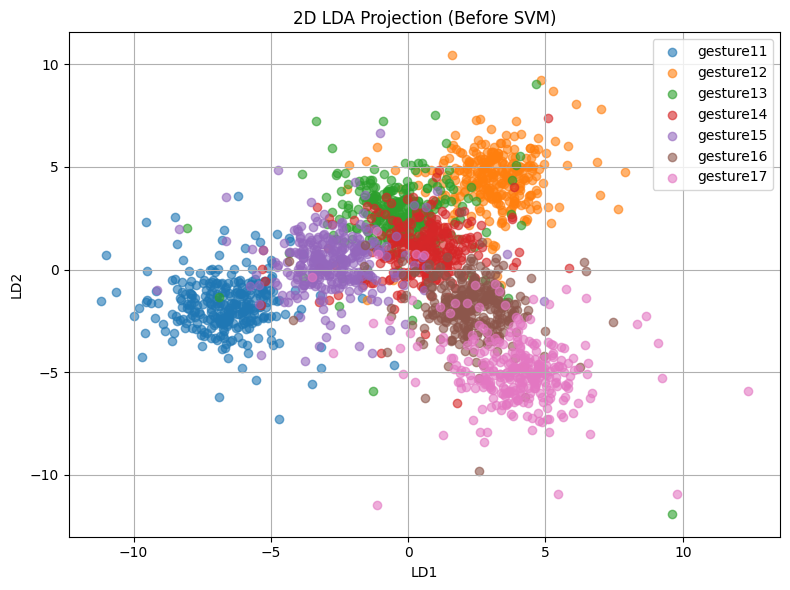

In [5]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import matplotlib.pyplot as plt

# # ================================
# # 📥 LOAD YOUR FEATURES CSV
# # ================================
# df = pd.read_csv(r"D:\MyoLinkVR\grabmyo\copyfeatures2_DWT.csv")

# # Flatten it
# df["feature_group"] = df["level"] + "_C" + df["channel"].astype(str)
# flat_df = df.melt(id_vars=["file", "feature_group"],
#                   value_vars=["MAV", "WL", "ZC", "SSC", "RMS", "EWL", "EMAV"],
#                   var_name="feature", value_name="value")
# flat_df["full_feature"] = flat_df["feature"] + "_" + flat_df["feature_group"]
# X_df = flat_df.pivot(index="file", columns="full_feature", values="value").reset_index()

# # ================================
# # 🏷️ Extract labels
# # ================================
# X_df["label"] = X_df["file"].apply(lambda f: [part for part in f.split("_") if "gesture" in part][0])

# X = X_df.drop(columns=["file", "label"])
# y = X_df["label"]

# # ================================
# # 🧪 Train-Test Split
# # ================================
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # ================================
# # 🔄 Normalize (Very Important for SVM!)
# # ================================
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # ================================
# # 📉 Apply LDA for Dimensionality Reduction
# # ================================
# lda = LinearDiscriminantAnalysis()
# X_train_lda = lda.fit_transform(X_train_scaled, y_train)
# X_test_lda = lda.transform(X_test_scaled)

# # ================================
# # 🤖 Train SVM on LDA Features
# # ================================
# svm = SVC(kernel='rbf', C=1, gamma='scale')  # You can tune C/gamma later
# svm.fit(X_train_lda, y_train)
# y_pred = svm.predict(X_test_lda)

# # ================================
# # 📊 Evaluation
# # ================================
# print("\n📊 Classification Report:")
# print(classification_report(y_test, y_pred))
# print("✅ Accuracy:", accuracy_score(y_test, y_pred))
# print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# # ================================
# # 📈 Optional 2D LDA Plot
# # ================================
# if X_train_lda.shape[1] >= 2:
#     X_all_lda = lda.transform(scaler.transform(X))
#     labels = np.unique(y)
#     plt.figure(figsize=(8, 6))
#     for label in labels:
#         idx = y == label
#         plt.scatter(X_all_lda[idx, 0], X_all_lda[idx, 1], label=label, alpha=0.6)
#     plt.xlabel("LD1")
#     plt.ylabel("LD2")
#     plt.title("2D LDA Projection (Before SVM)")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


📥 Loading feature data...
🏷️ Extracting gesture labels...
🔍 Tuning SVM with GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✅ Best SVM Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

📊 Classification Report:
              precision    recall  f1-score   support

   gesture11       0.77      0.95      0.85        60
   gesture12       0.77      0.73      0.75        60
   gesture13       0.72      0.73      0.73        60
   gesture14       0.73      0.62      0.67        61
   gesture15       0.57      0.57      0.57        60
   gesture16       0.80      0.85      0.82        60
   gesture17       0.80      0.70      0.75        61

    accuracy                           0.74       422
   macro avg       0.74      0.74      0.73       422
weighted avg       0.74      0.74      0.73       422

✅ Accuracy: 0.7369668246445498
🧩 Confusion Matrix:
 [[57  0  1  0  2  0  0]
 [ 2 44  4  1  3  3  3]
 [ 3  2 44  3  1  4  3]
 [ 2  6  3 38 10  1  1]
 [ 7  1  8

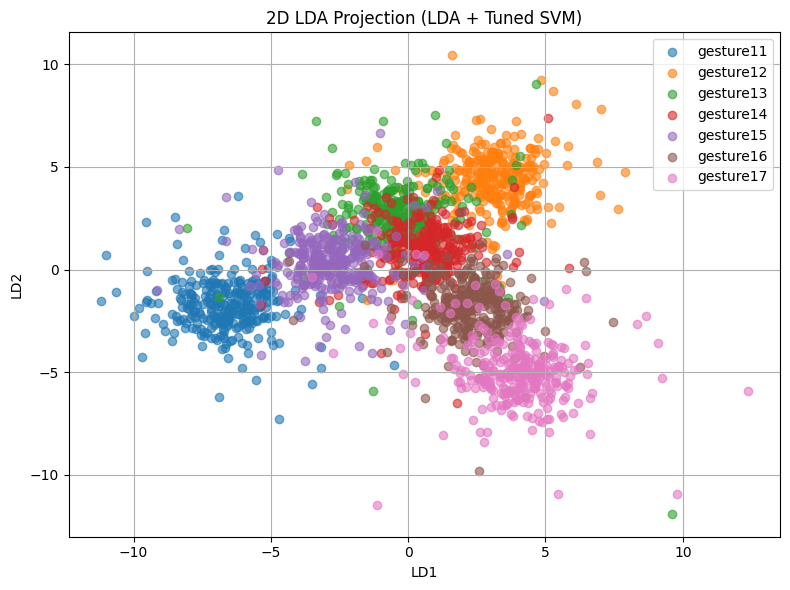

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ================================
# 📥 LOAD FEATURES
# ================================
print("📥 Loading feature data...")
FEATURES_CSV = r"D:\MyoLinkVR\grabmyo\copyfeatures2_DWT.csv"
df = pd.read_csv(FEATURES_CSV)

# Melt and pivot
df["feature_group"] = df["level"] + "_C" + df["channel"].astype(str)
flat_df = df.melt(id_vars=["file", "feature_group"],
                  value_vars=["MAV", "WL", "ZC", "SSC", "RMS", "EWL", "EMAV"],
                  var_name="feature", value_name="value")
flat_df["full_feature"] = flat_df["feature"] + "_" + flat_df["feature_group"]
X_df = flat_df.pivot(index="file", columns="full_feature", values="value").reset_index()

# ================================
# 🏷️ EXTRACT + FILTER LABELS
# ================================
print("🏷️ Extracting gesture labels...")
X_df["label"] = X_df["file"].apply(lambda f: [part for part in f.split("_") if "gesture" in part][0])
valid_gestures = ['gesture11', 'gesture12', 'gesture13', 'gesture14', 'gesture15', 'gesture16', 'gesture17']
X_df = X_df[X_df["label"].isin(valid_gestures)]

# ================================
# 🎯 PREP FEATURES + LABELS
# ================================
X = X_df.drop(columns=["file", "label"])
y = X_df["label"]

# ================================
# 🧪 TRAIN-TEST SPLIT
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ================================
# ⚖️ STANDARDIZE FOR SVM
# ================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ================================
# 📉 LDA DIMENSIONALITY REDUCTION
# ================================
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# ================================
# 🔍 GRID SEARCH SVM
# ================================
print("🔍 Tuning SVM with GridSearchCV...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=2, n_jobs=-1)
grid.fit(X_train_lda, y_train)

print(f"\n✅ Best SVM Params: {grid.best_params_}")
svm = grid.best_estimator_

# ================================
# ✅ PREDICT + EVALUATE
# ================================
y_pred = svm.predict(X_test_lda)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ================================
# 📈 2D LDA VISUALIZATION
# ================================
if X_train_lda.shape[1] >= 2:
    X_all_lda = lda.transform(scaler.transform(X))
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        idx = y == label
        plt.scatter(X_all_lda[idx, 0], X_all_lda[idx, 1], label=label, alpha=0.6)
    plt.xlabel("LD1")
    plt.ylabel("LD2")
    plt.title("2D LDA Projection (LDA + Tuned SVM)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


📥 Loading feature data...
🏷️ Extracting gesture labels...

📊 Classification Report:
              precision    recall  f1-score   support

   gesture11       0.78      0.95      0.86        60
   gesture12       0.75      0.78      0.76        60
   gesture13       0.70      0.73      0.72        60
   gesture14       0.76      0.64      0.70        61
   gesture15       0.58      0.55      0.56        60
   gesture16       0.81      0.83      0.82        60
   gesture17       0.79      0.69      0.74        61

    accuracy                           0.74       422
   macro avg       0.74      0.74      0.74       422
weighted avg       0.74      0.74      0.74       422

✅ Accuracy: 0.7393364928909952
🧩 Confusion Matrix:
 [[57  0  1  0  2  0  0]
 [ 1 47  3  2  3  2  2]
 [ 3  3 44  2  1  3  4]
 [ 2  6  4 39  7  2  1]
 [ 9  1 10  4 33  2  1]
 [ 0  3  0  0  4 50  3]
 [ 1  3  1  4  7  3 42]]


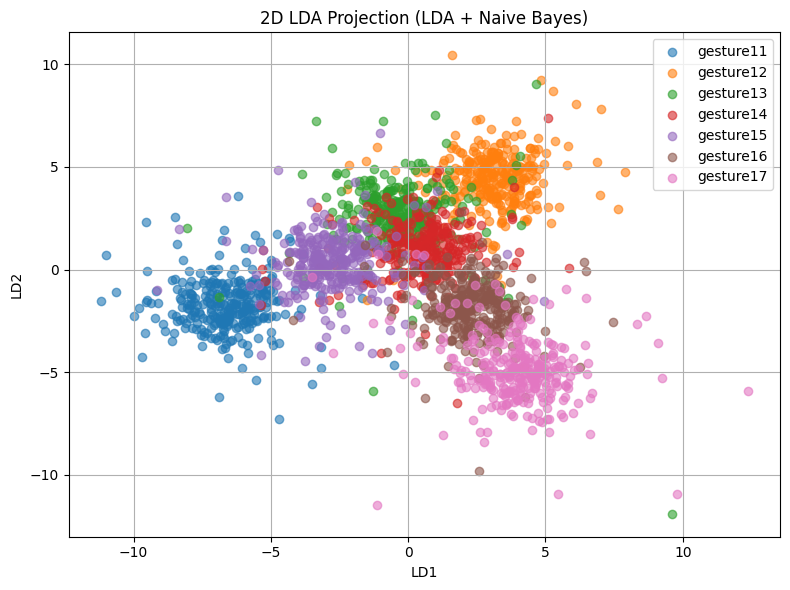

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ================================
# 📥 LOAD FEATURES
# ================================
print("📥 Loading feature data...")
FEATURES_CSV = r"D:\MyoLinkVR\grabmyo\copyfeatures_DWT.csv"
df = pd.read_csv(FEATURES_CSV)

# Melt and pivot
df["feature_group"] = df["level"] + "_C" + df["channel"].astype(str)
flat_df = df.melt(id_vars=["file", "feature_group"],
                  value_vars=["MAV", "WL", "ZC", "SSC", "RMS", "EWL", "EMAV"],
                  var_name="feature", value_name="value")
flat_df["full_feature"] = flat_df["feature"] + "_" + flat_df["feature_group"]
X_df = flat_df.pivot(index="file", columns="full_feature", values="value").reset_index()

# ================================
# 🏷️ EXTRACT & FILTER LABELS
# ================================
print("🏷️ Extracting gesture labels...")
X_df["label"] = X_df["file"].apply(lambda f: [part for part in f.split("_") if "gesture" in part][0])
valid_gestures = ['gesture11', 'gesture12', 'gesture13', 'gesture14', 'gesture15', 'gesture16', 'gesture17']
X_df = X_df[X_df["label"].isin(valid_gestures)]

# ================================
# 🎯 PREP FEATURES + LABELS
# ================================
X = X_df.drop(columns=["file", "label"])
y = X_df["label"]

# ================================
# 🧪 TRAIN-TEST SPLIT
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ================================
# ⚖️ STANDARDIZE
# ================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ================================
# 📉 LDA DIMENSIONALITY REDUCTION
# ================================
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# ================================
# 🧠 NAIVE BAYES CLASSIFIER
# ================================
nb = GaussianNB()
nb.fit(X_train_lda, y_train)
y_pred = nb.predict(X_test_lda)

# ================================
# ✅ EVALUATE RESULTS
# ================================
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ================================
# 📈 2D LDA VISUALIZATION
# ================================
if X_train_lda.shape[1] >= 2:
    X_all_lda = lda.transform(scaler.transform(X))
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        idx = y == label
        plt.scatter(X_all_lda[idx, 0], X_all_lda[idx, 1], label=label, alpha=0.6)
    plt.xlabel("LD1")
    plt.ylabel("LD2")
    plt.title("2D LDA Projection (LDA + Naive Bayes)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
